In [1]:
import sys
import math
import cv2 
import numpy as np
from matplotlib import pyplot as plt
import os

In [3]:
load_ext jupyternotify

<IPython.core.display.Javascript object>

# Computing distance to line

An essential part of getting the robot to behave correctly around street lights is for it to know its distance to the light. On actual roads in Switzerland and many other countries, at every light there is a stop line painted on the road. We do the same in our context and thus the distance to the street light is equivalent to the distance to the stop line on the road.

Below is an example of a typical picture taken by the robot during one of its runs, where the stop line is starting to appear. The whole set of pictures from that run can be found in the folder /images/.

![title](images/27.jpg)

Write a function that takes an image as input and returns a distance to the line (not necessarily in cm). To make sure it is robust, find a way to augment your test set from the given images.

Use OpenCV, which you can install through Anaconda, to process the images. Then you can choose between using the OpenCV library to detect the line or implementing your own procedure, keeping in mind that the function should be as fast as possible. 

### Theory, ideas 

We begin by detecting horizontal lines (hence the line we are interested in) using the probabilistic Hough transform.(which is musch faster than the simple one)

We preprocess the image using the Canny edge detection, then dilating the edges to be sure to have a good detection and to not miss the line (comparative tests should be done a little bit later to determine if this is really necessary)

Then we define our new distance as follows :  

![alt text](images/hnew_distance_explanation.jpg "Exemple of the lines actually detected (we ignored some vertical lines) from image 101 in the dataset")

This is one example of the image we get using the following code :  

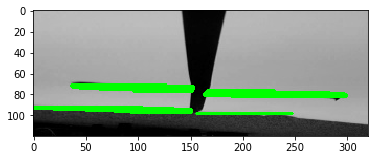

In [2]:
kernel = np.ones((5,5),np.uint8)
canny_max_val=500
canny_min_val=400
minLineLength = 100
maxLineGap = 50
threshold = 100
closer = 0
distance = 100000000000
epsilon = 20

#we load the image 
img = cv2.imread('images/101.jpg')

#we convert it to gray scale since we are interested in finding a black line over a white surface 
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#first canny edge detection
edges = cv2.Canny(gray,canny_min_val,canny_max_val,apertureSize = 3)

#then the dilatation
edges = cv2.dilate(edges,kernel)

#then the probabilistic Hough transform
lines = cv2.HoughLinesP(edges,1,np.pi/2,threshold,minLineLength,maxLineGap)

#visualisation
for index,line in enumerate(lines):
    for x1,y1,x2,y2 in line :
        if y2 != 0 and abs(y2-y1)<=epsilon:  #avoid finding vertical lines starting at the origin
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
        if y1<distance or y2 < distance:
            closer = index
            distance = min(y1,y2)   
plt.imshow(img)
plt.show()

The visualisation is not mandatory, but just helps us

The distance si defined as the distance between the origin (our robot) and the closest horizontal line : `distance` is defined this way so we are sure we didn't cross the line. 

One problem it might cause is that if the black line is in a curve (not real case...) this might give some bizarre results

We actually define the relative distance to the line as `dsitance`. But we have some problem with the "end of the world" detection : here are some solutions that shall be tested later : 
1. find the total length of the image in pixels (this is basically our new unit of distance) then when measuring distance, say that if the detected distance is superior to the length of the image minus a certain small distance (to be defined from experience) then consider the distance to be infinite : hence our robot will act as if there is no horizontal band 
2. find the horizon and try to find the actual band : this way if we have two bands we know that we are measuring actually the distance to a pseudo traffic light, otherwise proceed as told before.


but this may be not enough : the pictures are quite clear and clean in this dataset but otherwise we could think of apllying a gaussian blurr to delete noise.

Another improvement that could be make is that we could find the angle from a vertical in the lines we find : if this angle $\theta$ is too small we decide to not look at this line : hence we mininize the risk of detecting a length $0$ as we can have when we have perfectly vertical lines (or near perfect), for now this sorting is done by not taking into account lines that begin at $0$ but we might detect some starting near $0$ but not exactly and hence being trapped

we can now proceed to measuring the distance when we actually "move" : for each image where we measure the distance, we have to compare it to the previous distance(s) calculated and maybe to the one after

### Actual computations

minLineLength - Minimum length of line. Line segments shorter than this are rejected.


maxLineGap - Maximum allowed gap between line segments to treat them as single line.

1.jpg


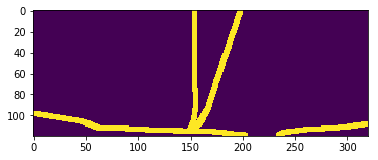

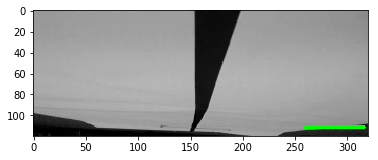

111
10.jpg


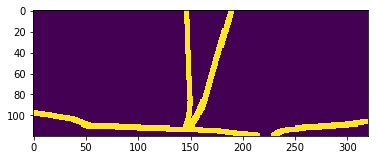

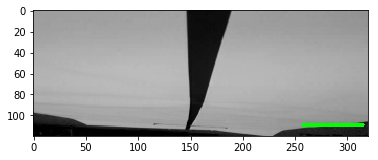

109
101.jpg


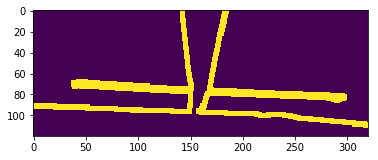

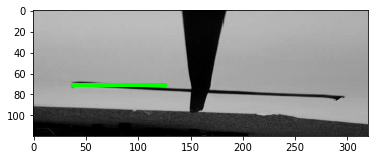

71
103.jpg


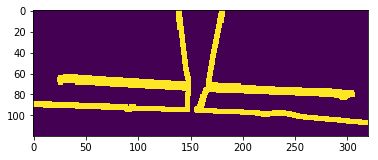

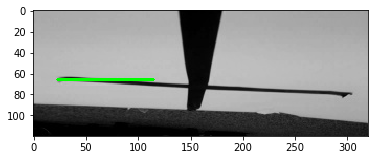

66
105.jpg


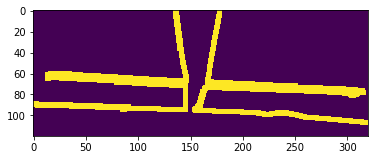

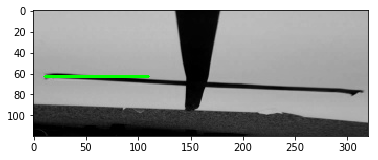

63
108.jpg


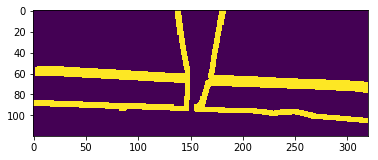

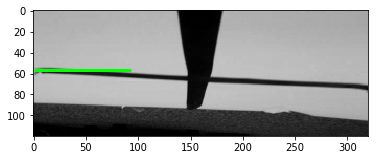

57
110.jpg


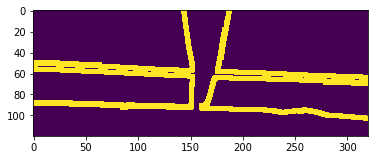

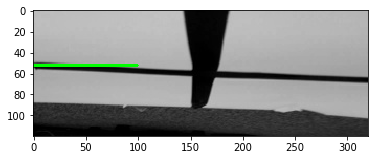

52
113.jpg


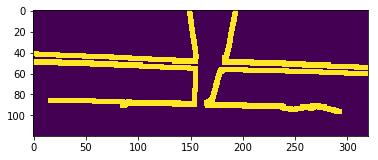

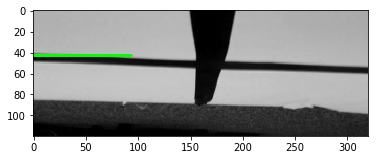

43
116.jpg


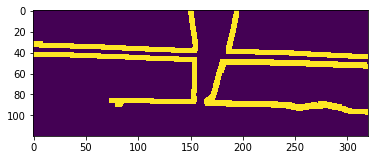

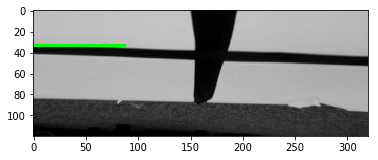

33
118.jpg


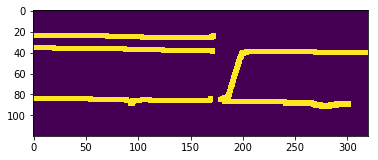

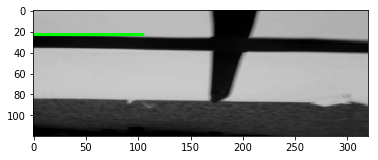

23
121.jpg


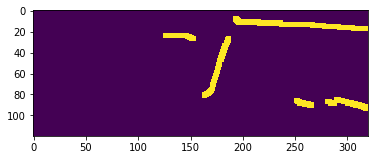

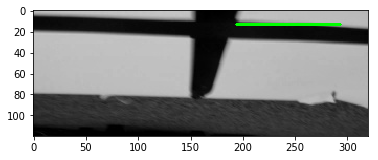

13
123.jpg


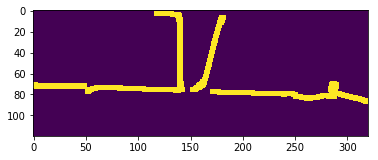

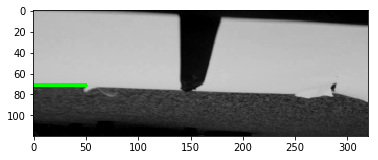

71
13.jpg


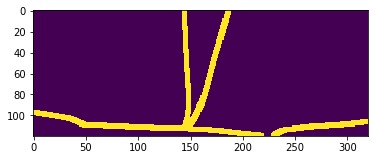

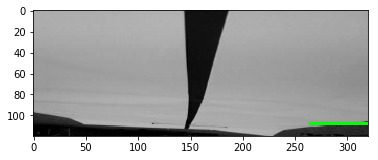

108
15.jpg


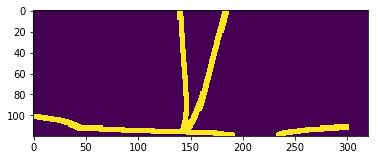

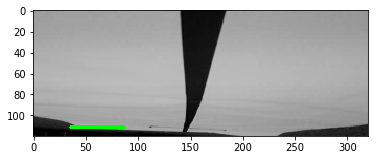

111
18.jpg


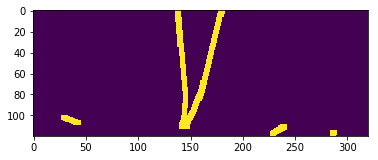

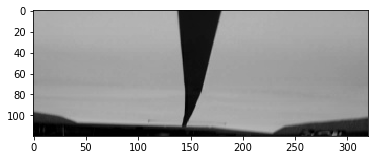

-20
20.jpg


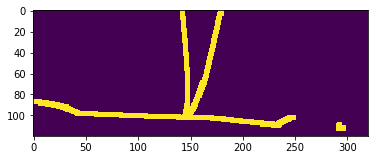

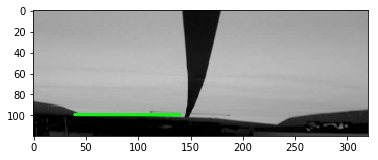

99
22.jpg


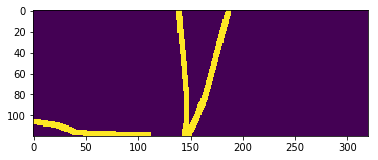

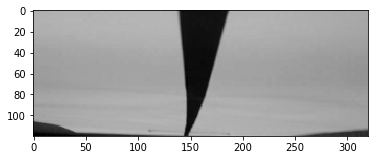

-20
25.jpg


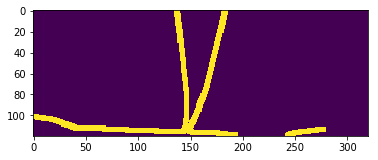

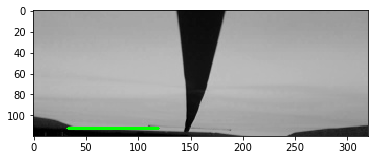

112
27.jpg


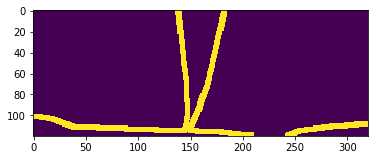

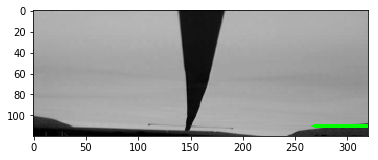

110
3.jpg


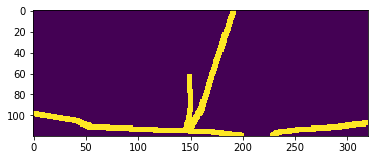

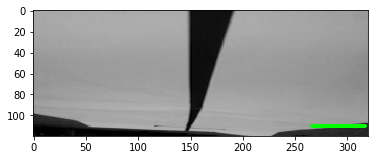

110
30.jpg


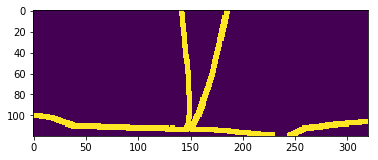

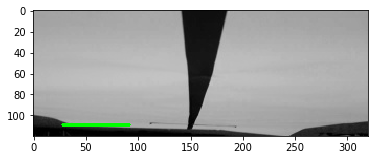

109
32.jpg


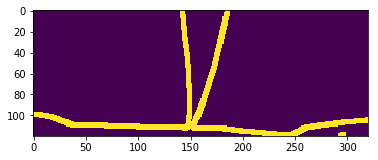

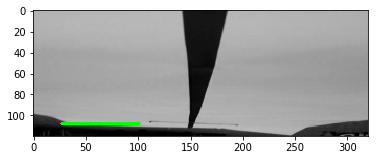

108
35.jpg


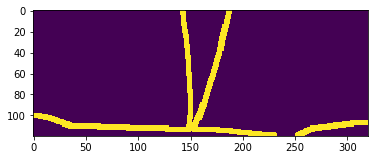

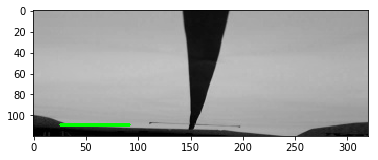

109
37.jpg


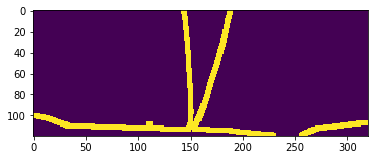

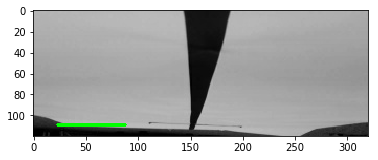

109
40.jpg


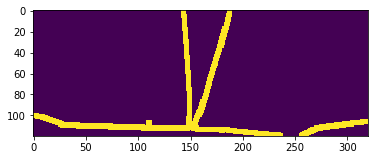

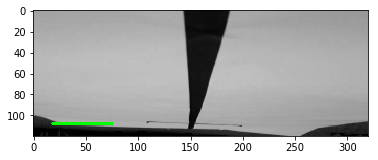

108
42.jpg


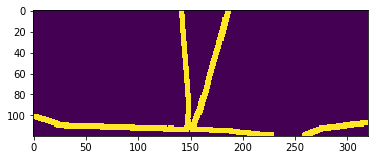

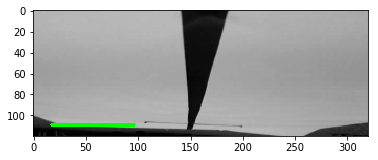

109
44.jpg


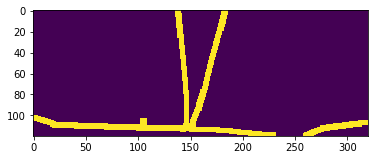

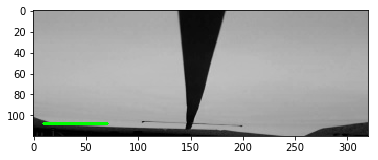

108
47.jpg


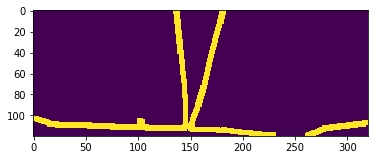

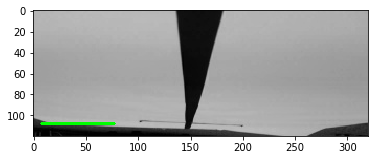

108
49.jpg


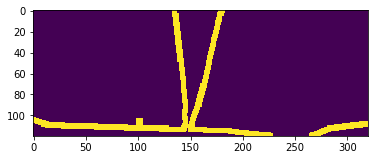

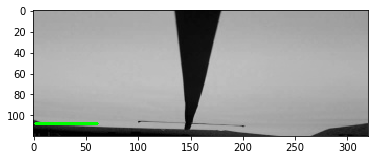

108
5.jpg


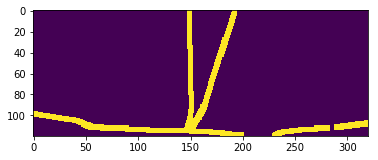

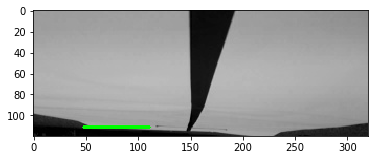

111
52.jpg


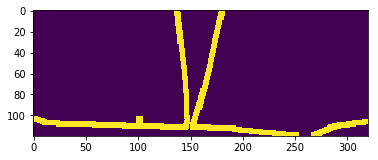

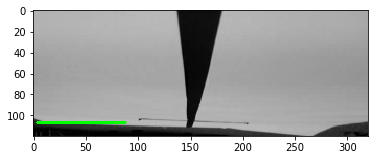

107
54.jpg


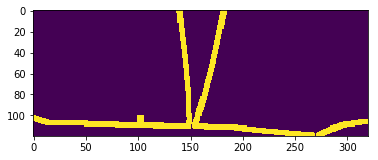

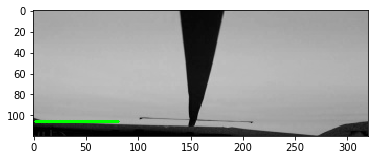

106
57.jpg


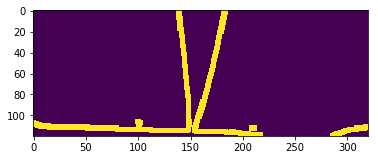

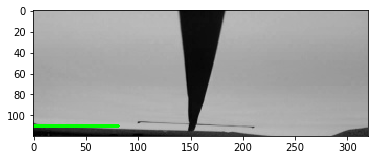

110
59.jpg


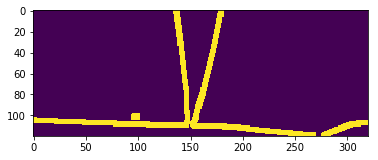

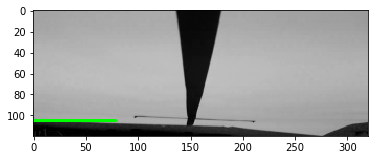

105
62.jpg


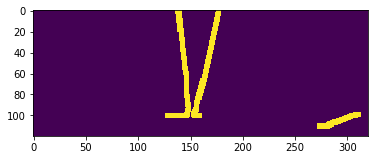

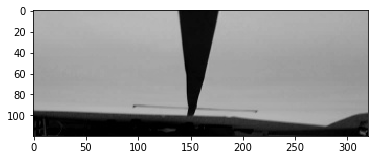

-20
64.jpg


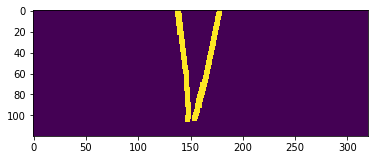

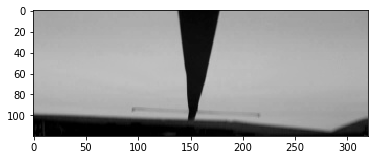

-20
66.jpg


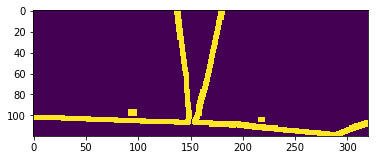

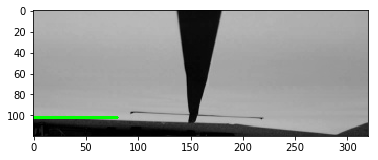

102
69.jpg


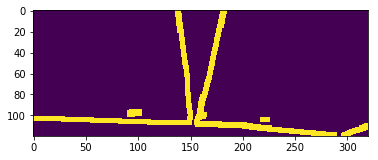

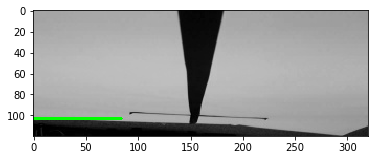

103
71.jpg


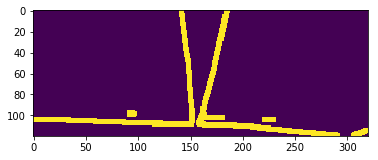

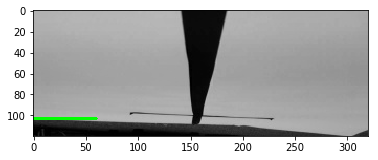

103
74.jpg


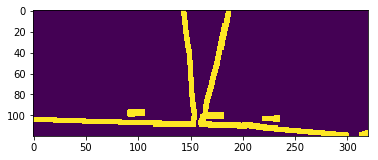

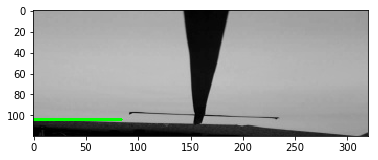

104
76.jpg


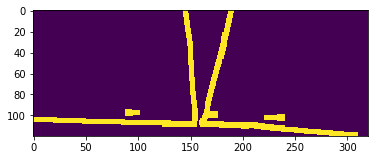

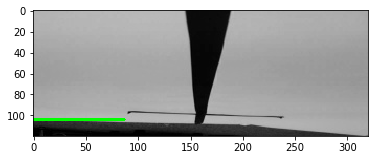

104
79.jpg


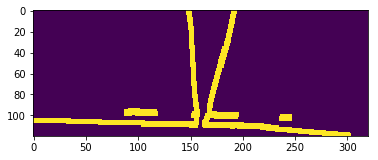

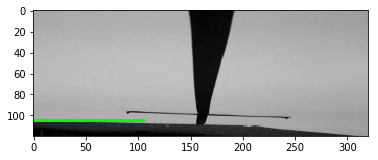

105
8.jpg


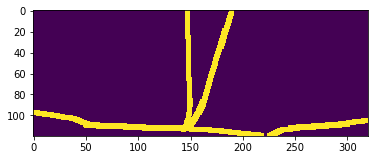

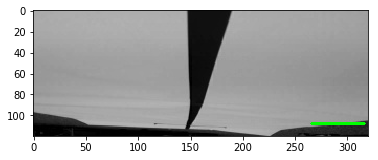

108
81.jpg


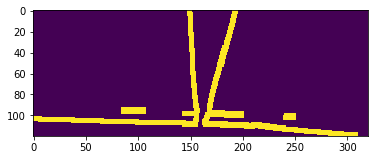

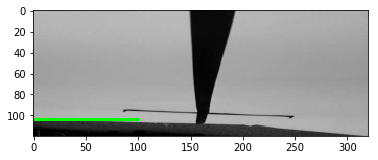

104
83.jpg


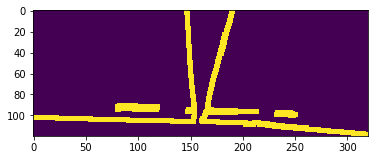

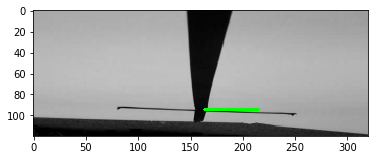

94
86.jpg


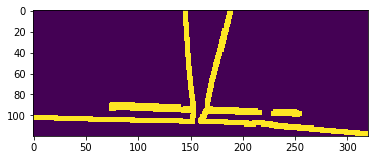

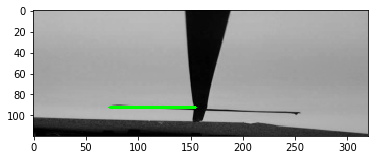

92
88.jpg


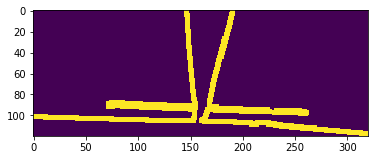

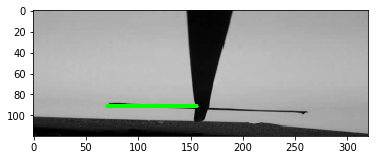

91
91.jpg


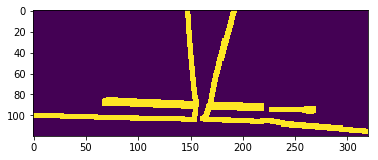

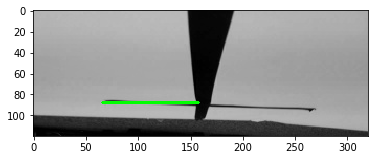

88
93.jpg


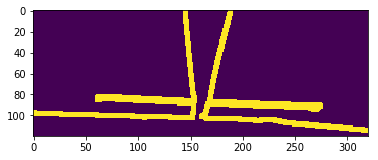

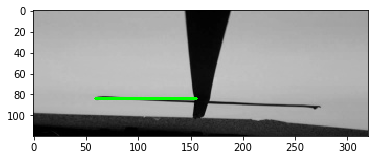

84
96.jpg


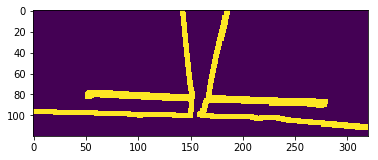

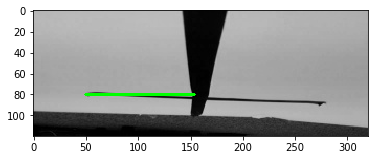

80
98.jpg


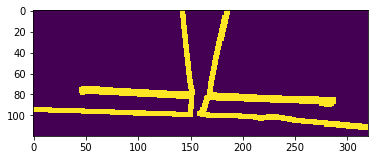

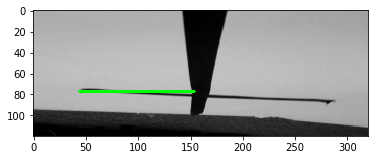

77


<IPython.core.display.Javascript object>

In [9]:

kernel = np.ones((5,5),np.uint8)
canny_max_val=500
canny_min_val=400
minLineLength = 100
maxLineGap = 50
threshold = 100


Data = []

for filename in os.listdir('images'):
    
    distance = -20
    closer = 0
    
    img = cv2.imread(os.path.join('images/'+filename))   #manque de robustesse : path devrait être un paramètre
    print(filename)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray,canny_min_val,canny_max_val,apertureSize = 3)
    edges = cv2.dilate(edges,kernel)
    plt.imshow(edges)
    plt.show()
    lines = cv2.HoughLinesP(edges,1,np.pi/2,threshold,minLineLength,maxLineGap)
    try :
        for index,line in enumerate(lines):
            for x1,y1,x2,y2 in line:
                if y2 != 0 and abs(y2-y1)<=epsilon:  #avoid finding vertical lines starting at the origin
                    if distance < 0:
                        distance = min(y1,y2)
                    elif y1<distance or y2 < distance:
                        closer = index
                        distance = min(y1,y2)   
        
        for x1,y1,x2,y2 in lines[closer]: 
            cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
    except : 
        pass
    
    Data.append([distance,closer,filename])
    #print(os.path.join('images/'+filename))
    plt.imshow(img)
    plt.show()    
    print(distance)

%notify

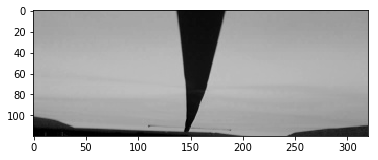

25.jpg
estimated distance to stopping line :  112 pixels 


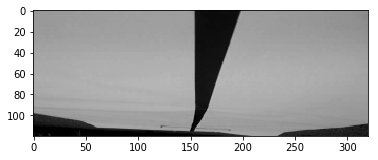

1.jpg
estimated distance to stopping line :  111 pixels 


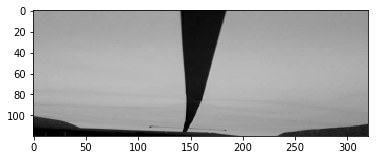

15.jpg
estimated distance to stopping line :  111 pixels 


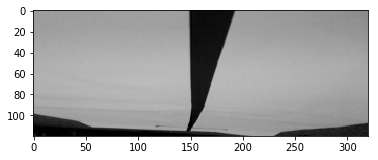

5.jpg
estimated distance to stopping line :  111 pixels 


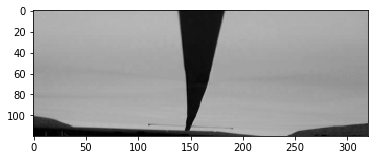

27.jpg
estimated distance to stopping line :  110 pixels 


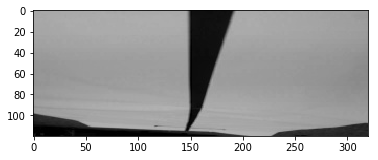

3.jpg
estimated distance to stopping line :  110 pixels 


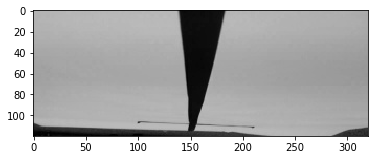

57.jpg
estimated distance to stopping line :  110 pixels 


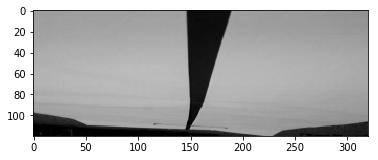

10.jpg
estimated distance to stopping line :  109 pixels 


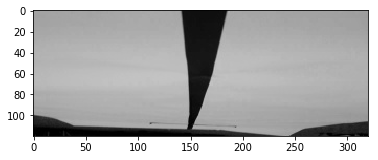

30.jpg
estimated distance to stopping line :  109 pixels 


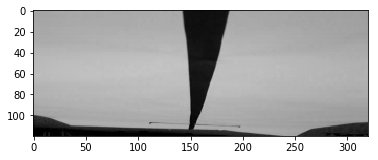

35.jpg
estimated distance to stopping line :  109 pixels 


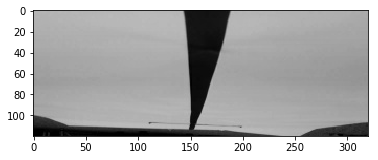

37.jpg
estimated distance to stopping line :  109 pixels 


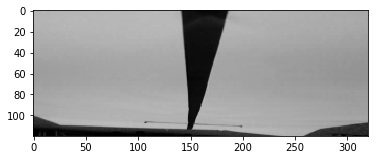

42.jpg
estimated distance to stopping line :  109 pixels 


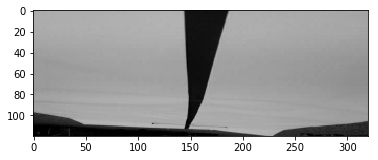

13.jpg
estimated distance to stopping line :  108 pixels 


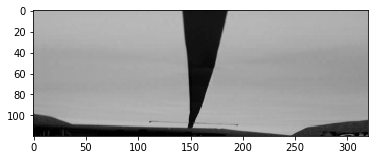

32.jpg
estimated distance to stopping line :  108 pixels 


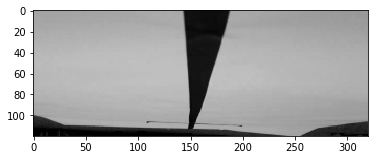

40.jpg
estimated distance to stopping line :  108 pixels 


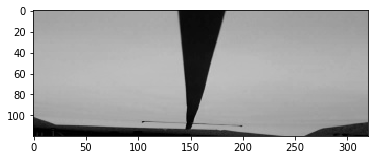

44.jpg
estimated distance to stopping line :  108 pixels 


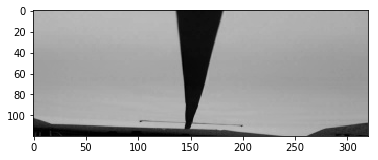

47.jpg
estimated distance to stopping line :  108 pixels 


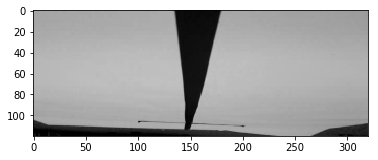

49.jpg
estimated distance to stopping line :  108 pixels 


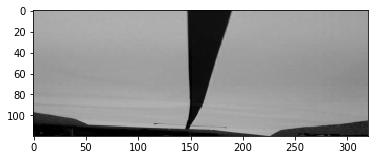

8.jpg
estimated distance to stopping line :  108 pixels 


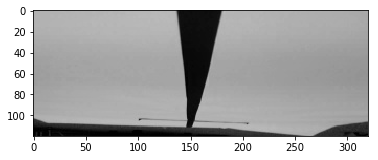

52.jpg
estimated distance to stopping line :  107 pixels 


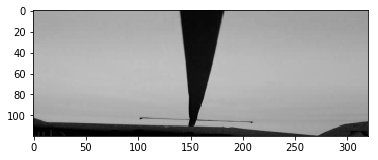

54.jpg
estimated distance to stopping line :  106 pixels 


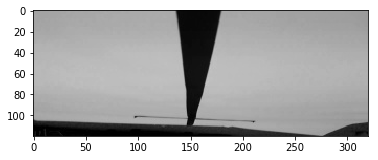

59.jpg
estimated distance to stopping line :  105 pixels 


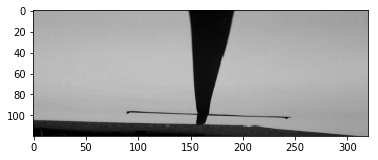

79.jpg
estimated distance to stopping line :  105 pixels 


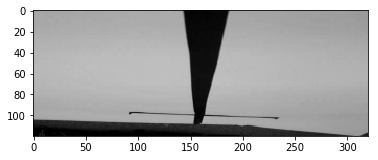

74.jpg
estimated distance to stopping line :  104 pixels 


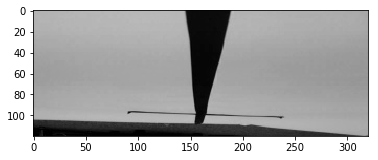

76.jpg
estimated distance to stopping line :  104 pixels 


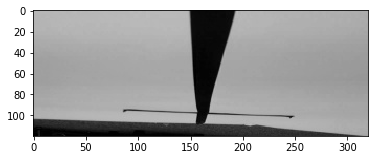

81.jpg
estimated distance to stopping line :  104 pixels 


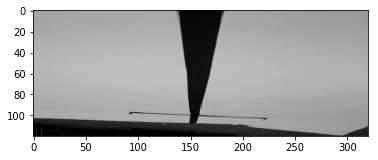

69.jpg
estimated distance to stopping line :  103 pixels 


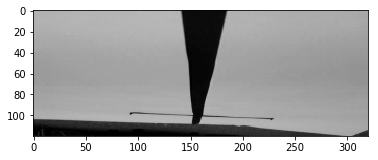

71.jpg
estimated distance to stopping line :  103 pixels 


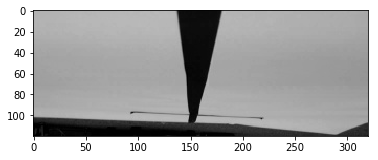

66.jpg
estimated distance to stopping line :  102 pixels 


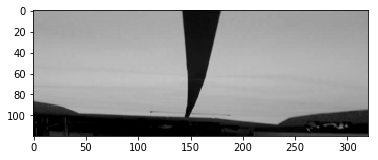

20.jpg
estimated distance to stopping line :  99 pixels 


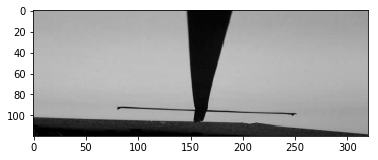

83.jpg
estimated distance to stopping line :  94 pixels 


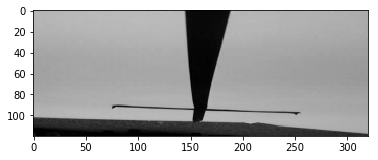

86.jpg
estimated distance to stopping line :  92 pixels 


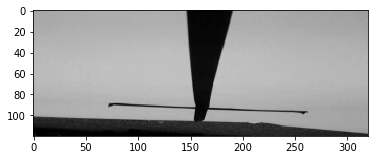

88.jpg
estimated distance to stopping line :  91 pixels 


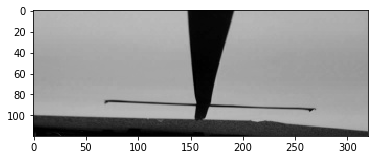

91.jpg
estimated distance to stopping line :  88 pixels 


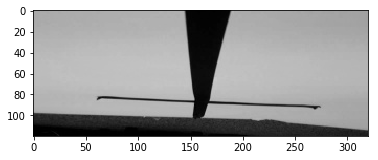

93.jpg
estimated distance to stopping line :  84 pixels 


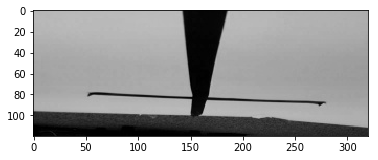

96.jpg
estimated distance to stopping line :  80 pixels 


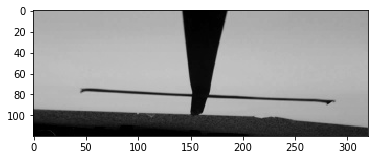

98.jpg
estimated distance to stopping line :  77 pixels 


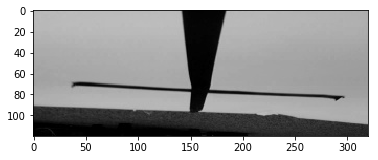

101.jpg
estimated distance to stopping line :  71 pixels 


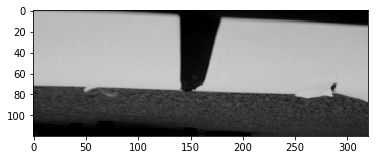

123.jpg
estimated distance to stopping line :  71 pixels 


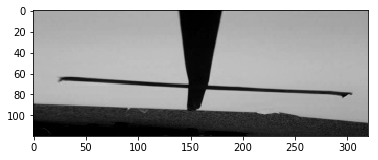

103.jpg
estimated distance to stopping line :  66 pixels 


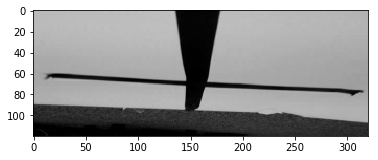

105.jpg
estimated distance to stopping line :  63 pixels 


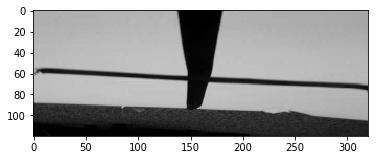

108.jpg
estimated distance to stopping line :  57 pixels 


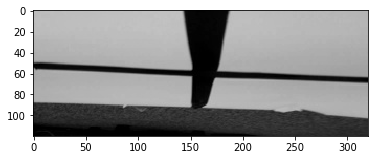

110.jpg
estimated distance to stopping line :  52 pixels 


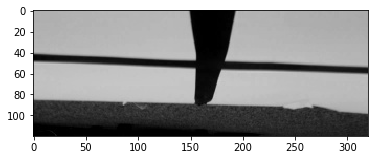

113.jpg
estimated distance to stopping line :  43 pixels 


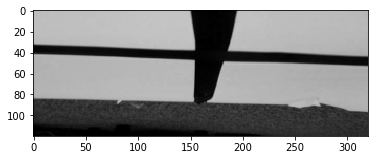

116.jpg
estimated distance to stopping line :  33 pixels 


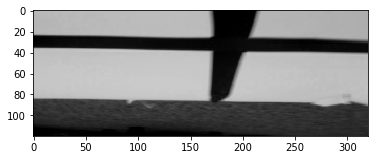

118.jpg
estimated distance to stopping line :  23 pixels 


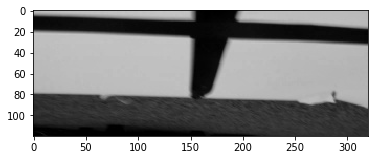

121.jpg
estimated distance to stopping line :  13 pixels 


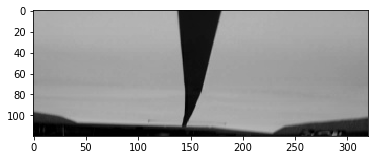

18.jpg
no stoppinng line detected


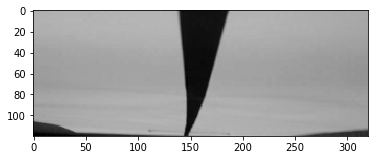

22.jpg
no stoppinng line detected


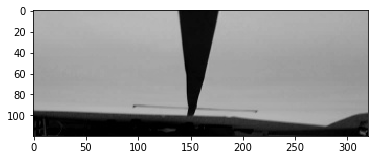

62.jpg
no stoppinng line detected


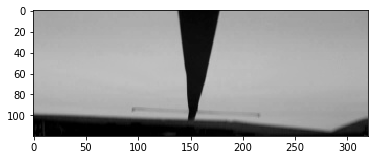

64.jpg
no stoppinng line detected


In [5]:
Data.sort(key=lambda x: -x[0])    #order by distance
for data in Data : 
    img = cv2.imread(os.path.join('images/'+data[2]))
    plt.imshow(img)
    plt.show()
    print(data[2])
    if data[0] == -20:
        print('no stoppinng line detected')
    else :
        print('estimated distance to stopping line : ',data[0],'pixels ')


The sorting w.r.t. distance (from the way the pictures were taken ) is supposed to yield the images in numerical order : 

In [6]:
for element in Data : 
    print(element[2],'   ',element[0])

25.jpg     112
1.jpg     111
15.jpg     111
5.jpg     111
27.jpg     110
3.jpg     110
57.jpg     110
10.jpg     109
30.jpg     109
35.jpg     109
37.jpg     109
42.jpg     109
13.jpg     108
32.jpg     108
40.jpg     108
44.jpg     108
47.jpg     108
49.jpg     108
8.jpg     108
52.jpg     107
54.jpg     106
59.jpg     105
79.jpg     105
74.jpg     104
76.jpg     104
81.jpg     104
69.jpg     103
71.jpg     103
66.jpg     102
20.jpg     99
83.jpg     94
86.jpg     92
88.jpg     91
91.jpg     88
93.jpg     84
96.jpg     80
98.jpg     77
101.jpg     71
123.jpg     71
103.jpg     66
105.jpg     63
108.jpg     57
110.jpg     52
113.jpg     43
116.jpg     33
118.jpg     23
121.jpg     13
18.jpg     -20
22.jpg     -20
62.jpg     -20
64.jpg     -20


To resolve some of the problem (cf image `123.png`) an "end of the white paper procedure could help"

In [ ]:
def end_of_paper(image)
#load an image with its path : if you want to load 103.png just give images/103.png

img=cv2.imread(image)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,canny_min_val,canny_max_val,apertureSize = 3)
edges = cv2.dilate(edges,kernel)


### Tests/garbage

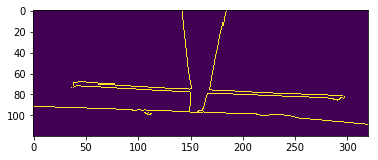

[[[ 0 91 48 92]]]


True

In [38]:
import cv2
import numpy as np

img = cv2.imread('images/101.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,100,200,apertureSize = 3)
plt.imshow(edges)
plt.show()
minLineLength = 0.1
maxLineGap = 40
lines = cv2.HoughLinesP(edges,1,np.pi/360,100,minLineLength,maxLineGap)
print(lines)
for line in lines:
    for x1,y1,x2,y2 in line :
        cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

cv2.imwrite('images/houghlines5.jpg',img)

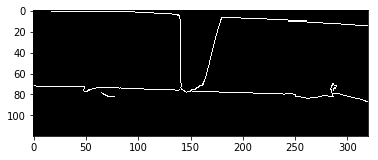

In [33]:
img=cv2.imread('images/123.jpg')
edges=cv2.Canny(img,150,200)
plt.imshow(edges, cmap = 'gray')
plt.show()